In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "data/train/input_2023_w01.csv"
OUTPUT_PATH = "data/train/output_2023_w01.csv"
SUPP_PATH = "data/supplementary_data.csv"

inp = pd.read_csv(INPUT_PATH)
out = pd.read_csv(OUTPUT_PATH)
supp = pd.read_csv(SUPP_PATH)

print(inp.shape, out.shape, supp.shape)


(285714, 23) (32088, 6) (18009, 41)


/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_9400/467990847.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp = pd.read_csv(SUPP_PATH)


In [2]:
role_cols = [
    "game_id", "play_id", "nfl_id",
    "player_name", "player_position", "player_side", "player_role",
    "play_direction", "absolute_yardline_number"
]

role_map = (
    inp[role_cols]
    .drop_duplicates(subset=["game_id", "play_id", "nfl_id"])
)

out_role = out.merge(role_map, on=["game_id", "play_id", "nfl_id"], how="left")

play_meta_cols = [
    "game_id", "play_id",
    "pass_result", "pass_length", "pass_location_type",
    "route_of_targeted_receiver"
]
play_meta = supp[play_meta_cols].drop_duplicates(subset=["game_id", "play_id"])

out_role = out_role.merge(play_meta, on=["game_id", "play_id"], how="left")

out_role.head()


,game_id,play_id,nfl_id,frame_id,x,y,player_name,player_position,player_side,player_role,play_direction,absolute_yardline_number,pass_result,pass_length,pass_location_type,route_of_targeted_receiver
0,2023090700,101,46137,1,56.22,17.28,Justin Reid,SS,Defense,Defensive Coverage,right,42,I,22,INSIDE_BOX,CORNER
1,2023090700,101,46137,2,56.63,16.88,Justin Reid,SS,Defense,Defensive Coverage,right,42,I,22,INSIDE_BOX,CORNER
2,2023090700,101,46137,3,57.06,16.46,Justin Reid,SS,Defense,Defensive Coverage,right,42,I,22,INSIDE_BOX,CORNER
3,2023090700,101,46137,4,57.48,16.02,Justin Reid,SS,Defense,Defensive Coverage,right,42,I,22,INSIDE_BOX,CORNER
4,2023090700,101,46137,5,57.91,15.56,Justin Reid,SS,Defense,Defensive Coverage,right,42,I,22,INSIDE_BOX,CORNER


In [3]:
def find_candidate_plays(df: pd.DataFrame, min_defenders: int = 2, n: int = 10):
    grp = df.groupby(["game_id", "play_id"])
    candidates = []
    for (gid, pid), g in grp:
        has_tr = (g["player_role"] == "Targeted Receiver").any()
        n_def = (g["player_role"] == "Defensive Coverage").sum()
        if has_tr and n_def >= min_defenders:
            candidates.append((gid, pid, n_def))
    candidates = sorted(candidates, key=lambda x: x[2], reverse=True)
    return candidates[:n]

cands = find_candidate_plays(out_role, min_defenders=2, n=10)

print("Candidate plays (game_id, play_id, n_defenders):")
for c in cands:
    print(c)

GAME_ID, PLAY_ID, _ = cands[0]
print("\nSelected:", GAME_ID, PLAY_ID)


Candidate plays (game_id, play_id, n_defenders):
(2023091100, 3167, 658)
(2023091011, 3976, 174)
(2023091002, 1260, 170)
(2023091005, 3875, 170)
(2023091010, 1513, 138)
(2023091010, 607, 130)
(2023091100, 2428, 130)
(2023091006, 2188, 120)
(2023091010, 3064, 115)
(2023090700, 4041, 114)

Selected: 2023091100 3167


In [4]:
def catch_window_for_play(df: pd.DataFrame, game_id: int, play_id: int, radius_yards: float = 2.0):
    g = df[(df.game_id == game_id) & (df.play_id == play_id)].copy()

    tr = g[g["player_role"] == "Targeted Receiver"].copy()
    if tr.empty:
        raise ValueError("No Targeted Receiver found for this play.")

    # If multiple candidates exist, pick receiver with most frames
    tr_counts = tr.groupby("nfl_id")["frame_id"].count().sort_values(ascending=False)
    tr_id = int(tr_counts.index[0])
    tr = g[g["nfl_id"] == tr_id].sort_values("frame_id")

    defs = g[g["player_role"] == "Defensive Coverage"].copy()
    if defs.empty:
        raise ValueError("No Defensive Coverage players found for this play.")

    # Landing point proxy = targeted receiver's final position in air frames
    last_frame = int(tr["frame_id"].max())
    land_x = float(tr.loc[tr["frame_id"] == last_frame, "x"].iloc[0])
    land_y = float(tr.loc[tr["frame_id"] == last_frame, "y"].iloc[0])

    tr["rec_dist"] = np.sqrt((tr["x"] - land_x)**2 + (tr["y"] - land_y)**2)

    def_dists = []
    for fid, frame_df in defs.groupby("frame_id"):
        frame_df = frame_df.copy()
        frame_df["def_dist"] = np.sqrt((frame_df["x"] - land_x)**2 + (frame_df["y"] - land_y)**2)
        best = frame_df.sort_values("def_dist").iloc[0]
        def_dists.append((int(fid), float(best["def_dist"]), int(best["nfl_id"]), best.get("player_name", None)))

    def_dists = pd.DataFrame(def_dists, columns=["frame_id", "min_def_dist", "closest_def_id", "closest_def_name"])

    series = tr[["frame_id", "x", "y", "rec_dist", "player_name"]].merge(def_dists, on="frame_id", how="left")

    series["window_margin"] = series["min_def_dist"] - series["rec_dist"]
    series["window_open"] = (series["rec_dist"] <= radius_yards) & (series["window_margin"] > 0)

    meta = {
        "game_id": game_id,
        "play_id": play_id,
        "target_nfl_id": tr_id,
        "target_name": tr["player_name"].iloc[0],
        "last_frame": last_frame,
        "landing_x": land_x,
        "landing_y": land_y,
        "pass_result": g["pass_result"].iloc[0] if "pass_result" in g.columns else None,
        "route": g["route_of_targeted_receiver"].iloc[0] if "route_of_targeted_receiver" in g.columns else None,
        "radius_yards": radius_yards,
    }
    return series, g, meta

series, gplay, meta = catch_window_for_play(out_role, GAME_ID, PLAY_ID, radius_yards=2.0)

meta, series.head()


({'game_id': 2023091100,
  'play_id': 3167,
  'target_nfl_id': 54475,
  'target_name': 'Garrett Wilson',
  'last_frame': 94,
  'landing_x': 12.94,
  'landing_y': 40.8,
  'pass_result': 'C',
  'route': 'CORNER',
  'radius_yards': 2.0},
    frame_id      x      y   rec_dist     player_name  min_def_dist  \
 0         1  23.03  40.99  10.091789  Garrett Wilson      1.785721   
 1         2  22.57  41.51   9.656138  Garrett Wilson      1.266491   
 2         3  22.13  42.01   9.269315  Garrett Wilson      0.728011   
 3         4  21.72  42.49   8.941169  Garrett Wilson      0.264197   
 4         5  21.35  42.95   8.680472  Garrett Wilson      0.519711   
 
    closest_def_id closest_def_name  window_margin  window_open  
 0           40166     Jordan Poyer      -8.306068        False  
 1           40166     Jordan Poyer      -8.389647        False  
 2           40166     Jordan Poyer      -8.541304        False  
 3           40166     Jordan Poyer      -8.676972        False  
 4     

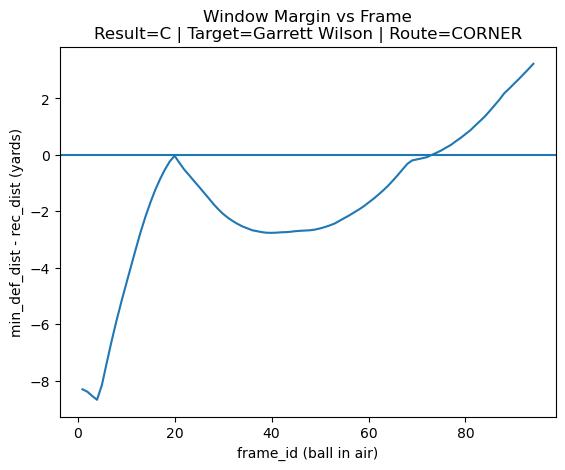

In [5]:
plt.figure()
plt.plot(series["frame_id"], series["window_margin"])
plt.axhline(0)
plt.title(f"Window Margin vs Frame\nResult={meta['pass_result']} | Target={meta['target_name']} | Route={meta['route']}")
plt.xlabel("frame_id (ball in air)")
plt.ylabel("min_def_dist - rec_dist (yards)")
plt.show()


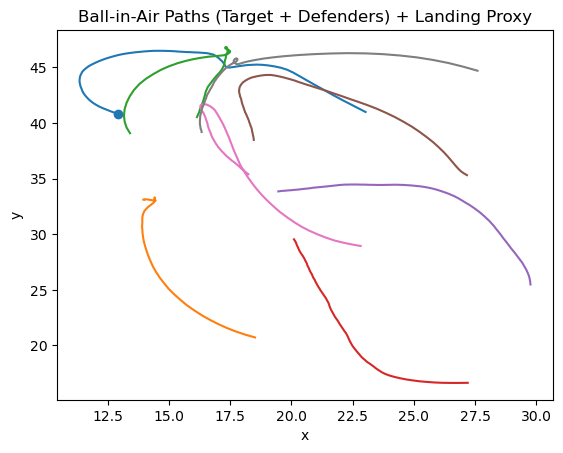

In [6]:
plt.figure()

# Target path
tr_id = meta["target_nfl_id"]
tr_path = gplay[gplay["nfl_id"] == tr_id].sort_values("frame_id")
plt.plot(tr_path["x"], tr_path["y"])

# Defender paths
defs = gplay[gplay["player_role"] == "Defensive Coverage"]
for did, dpath in defs.groupby("nfl_id"):
    dpath = dpath.sort_values("frame_id")
    plt.plot(dpath["x"], dpath["y"])

# Landing proxy
plt.scatter([meta["landing_x"]], [meta["landing_y"]])

plt.title("Ball-in-Air Paths (Target + Defenders) + Landing Proxy")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [7]:
open_frames = int(series["window_open"].sum())
total_frames = int(series.shape[0])

print("Play:", meta["game_id"], meta["play_id"])
print("Target:", meta["target_name"], "| Route:", meta["route"], "| Result:", meta["pass_result"])
print(f"Window open frames: {open_frames}/{total_frames} ({open_frames/total_frames:.1%})")

print("\nClosest defender (most frequent):")
print(series["closest_def_name"].value_counts().head(5))


Play: 2023091100 3167
Target: Garrett Wilson | Route: CORNER | Result: C
Window open frames: 11/94 (11.7%)

Closest defender (most frequent):
Terrel Bernard       49
Jordan Poyer         25
Christian Benford    20
Name: closest_def_name, dtype: int64
